In [1]:
import boto3
import os
from dotenv import load_dotenv
from pdf2image import convert_from_path
import pandas as pd
import pdb
from merge_dataframes import merge_dataframes
import argparse
import matplotlib.pyplot as plt
# from get_column_borders import get_column_borders
# from get_row_borders import get_row_borders
from ocr_pipeline import get_column_borders, get_row_borders, check_y_coordinate_spacing, find_header_row, find_record_continued_from_previous_page

# Load AWS credentials and region from .env file
load_dotenv()

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
region_name = os.getenv('AWS_REGION')


In [2]:
# Initialize the Textract client
client = boto3.client('textract', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name=region_name)

# # Create an argument parser
# parser = argparse.ArgumentParser(description="Generate an output path based on the PDF file path")
# parser.add_argument("pdf_path", help="Path to the PDF file")
# args = parser.parse_args()

pdf_path = '../data/input/allianz_1_page.pdf'

# # Convert each page of the PDF to images and process with Textract
# images = convert_from_path(args.pdf_path)

images = convert_from_path(pdf_path)

# Define the subfolder name for CSV files
output_folder = 'data/output'

# Generate the CSV folder path by manipulating the PDF path
pdf_base_name = os.path.splitext(os.path.basename(pdf_path))[0]
csv_folder = os.path.join(output_folder, pdf_base_name)


In [3]:
image = images[0]
page_number = 1

# Define the CSV file path with the subfolder
csv_path = os.path.join(csv_folder, 'page_{}.csv'.format(page_number))

# Save the PNG image to a temporary file
image.save('page_{}.png'.format(page_number), 'PNG')

# Read the local image
with open('page_{}.png'.format(page_number), 'rb') as image_file:
    image_binary = image_file.read()

# Call Textract to analyze the image
response = client.detect_document_text(
    Document={
        'Bytes': image_binary
    }
)


In [4]:
# CELL 3

'''This section of code is used to find the header row with the numbers 1, 2, 3, 4, 5, 6, and 7 by
checking if there are 7 blocks in a row that meet those criteria.'''

numbers, last_sequence_block = find_header_row(response)


text: 7
expected_text: ['1', '2', '3', '4', '5', '6', '7']
consecutive_matches: 0
text: 1
expected_text: ['1', '2', '3', '4', '5', '6', '7']
consecutive_matches: 0
text: 2
expected_text: ['2', '3', '4', '5', '6', '7']
consecutive_matches: 1
text: 3
expected_text: ['3', '4', '5', '6', '7']
consecutive_matches: 2
text: 4
expected_text: ['4', '5', '6', '7']
consecutive_matches: 3
text: 5
expected_text: ['5', '6', '7']
consecutive_matches: 4
text: 6
expected_text: ['6', '7']
consecutive_matches: 5
text: 7
expected_text: ['7']
consecutive_matches: 6
All seven expected numbers were found.
The y-coordinates are: [0.12581057846546173, 0.12558835744857788, 0.1263037621974945, 0.12684094905853271, 0.12717360258102417, 0.12992218136787415, 0.13197192549705505]
The mean distances between the y-coordinates are: [0.002230291565259298, 0.0024154757459958396, 0.00198369969924291, 0.0018941685557365417, 0.0019496108094851177, 0.0033239002029101052, 0.0050320203105608625]


In [5]:
# CELL 4

'''From the seven numbers in the header row, we determine the borders of the columns each number is the head of.'''

x_dividers = []

first_line = True

for number in numbers[1:6]:
    left, right = get_column_borders(number, image)

    if first_line:
        x_dividers.append(left)
        x_dividers.append(right)
        first_line = False

    else:
        x_dividers.append(right)

In [6]:
# Initialize seven groups to store LINE objects
line_groups = [[] for _ in range(7)]

for block in response['Blocks'][last_sequence_block:]:
    if block['BlockType'] == 'LINE':
        bbox = block['Geometry']['BoundingBox']
        left = bbox['Left']
        width = bbox['Width']

        # Calculate the center_x coordinate of the LINE object
        center_x = left + width / 2

        # Iterate through x_dividers to check where center_x belongs
        for i, divider in enumerate(x_dividers):
            if center_x < divider:
                # Append the LINE object to the corresponding list
                line_groups[i].append(block)
                break
        else:
            # If the center_x is greater than the last divider, assign it to the last group
            line_groups[-1].append(block)

In [7]:
y_dividers = []

first_line = True

for line in line_groups[0]:
    top, bottom = get_row_borders(line, image)

    if first_line:
        y_dividers.append(top)
        y_dividers.append(bottom)
        first_line = False

    else:
        y_dividers.append(bottom)

print(y_dividers)

[0.3351482153660012, 0.4670296430732002, 0.5940713853599516, 0.9909255898366606]


In [8]:
# catch continued entries from the previous page

smallest_y_divider = min(y_dividers)

# Initialize an empty list to store the filtered line groups
filtered_line_groups_no_entry_number = []
filtered_line_groups = []

# Iterate through the line_groups
for group in line_groups:
    # Filter the LINE objects in the current group
    filtered_group = [line for line in group if line['Geometry']['BoundingBox']['Top'] < smallest_y_divider]
    
    # Add the filtered group to the result
    filtered_line_groups_no_entry_number.append(filtered_group)

In [9]:
# within each list, join the texts together and keep the line breaks, return the list of seven strings
# for each line group, join the texts together and keep the line breaks
# return the list of seven strings

# Initialize an empty list to store the joined texts
joined_texts = []

# Iterate through the filtered_line_groups

for group in filtered_line_groups_no_entry_number:
    # join all the texts together and keep the line breaks
    joined_text = '\n'.join([line['Text'] for line in group])

    # Add the joined text to the result
    joined_texts.append(joined_text)

joined_texts

# if joined_texts[0] is empty, add the number of the previous entry number

# the previous entry is the last entry of the first column of the previous CSV in the folder: First idea:
# previous_csv_path = os.path.join(csv_folder, 'page_{}.csv'.format(page_number - 1))
# previous_df = pd.read_csv(previous_csv_path)
# previous_entry_number = previous_df.iloc[-1, 0]

previous_entry_number = "33"

if joined_texts[0] == "":
    joined_texts[0] = previous_entry_number
else:
    # log an error here and break the program so that the document is not processed further
    print("note: log an error here and break the program so that the document is not processed any further")


In [10]:
joined_texts

filtered_line_groups.append(joined_texts)

filtered_line_groups

[['33',
  '',
  '',
  '',
  'Prokura gemeinsam mit einem Vor-\nstandsmitglied oder einem anderen\nProkuristen beschränkt auf die\nZweigniederlassung Hannover:\nDr. Heine Ulf Dieter, Haenigsen.\nProkura gemeinsam mit einem Vor-\nstandsmitglied oder einem anderen\nProkuristen beschränkt auf die\nZweigniederlassung Karlsruhe:\nSchmid Walter, Waldbronn.',
  '',
  '']]

In [11]:
filtered_line_groups = []

print("result of find_record_continued_from_previous_page: ", find_record_continued_from_previous_page(line_groups, y_dividers))

# check if there is a continued entry from the previous page
if find_record_continued_from_previous_page(line_groups, y_dividers):
    continued_entry = find_record_continued_from_previous_page(line_groups, y_dividers)
    # add the record to the filtered_line_groups
    filtered_line_groups.append(continued_entry)
    print("continued entry found")

# Iterate through pairs of adjacent y_dividers
for i in range(len(y_dividers) - 1):
    lower_bound = y_dividers[i]
    upper_bound = y_dividers[i + 1]

    # Initialize a filtered group for this range
    filtered_group = []

    # Iterate through the line groups
    for group in line_groups:
        # Filter and join the LINE texts in the current group for this range
        filtered_text = "\n".join(line['Text'] for line in group if lower_bound <= line['Geometry']['BoundingBox']['Top'] < upper_bound)
        
        filtered_group.append(filtered_text)

    # Add the filtered group to the result
    filtered_line_groups.append(filtered_group)

joined_texts: ['33', '', '', '', 'Prokura gemeinsam mit einem Vor-\nstandsmitglied oder einem anderen\nProkuristen beschränkt auf die\nZweigniederlassung Hannover:\nDr. Heine Ulf Dieter, Haenigsen.\nProkura gemeinsam mit einem Vor-\nstandsmitglied oder einem anderen\nProkuristen beschränkt auf die\nZweigniederlassung Karlsruhe:\nSchmid Walter, Waldbronn.', '', '']
result of find_record_continued_from_previous_page:  None
joined_texts: ['33', '', '', '', 'Prokura gemeinsam mit einem Vor-\nstandsmitglied oder einem anderen\nProkuristen beschränkt auf die\nZweigniederlassung Hannover:\nDr. Heine Ulf Dieter, Haenigsen.\nProkura gemeinsam mit einem Vor-\nstandsmitglied oder einem anderen\nProkuristen beschränkt auf die\nZweigniederlassung Karlsruhe:\nSchmid Walter, Waldbronn.', '', '']


In [12]:
filtered_line_groups

[['34',
  '',
  '88.000.000,',
  '',
  '',
  'Auf Grund der in der Satzung enthaltenen Ermächtigung ist\ndie Erhöhung des Grundkapitals um 11.000.000,-- DM auf\n88.000.000, DM durchgeführt. Durch Beschluß des Auf-\nsichtsrates vom 9. Dezember 1981 ist § 2 der Satzung\n(Grundkapital; genehmigtes Kapital) geändert.',
  'a) 29, Jan. 1982\nStemeres\nb) Beschluß des AR\nB1. 868 SB\nneue Satzung\nBl. 870 SB'],
 ['35',
  '',
  '99.000.000,',
  '',
  '',
  'Das Grundkapital ist nach dem Beschluß der Hauptversamm-\nlung vom 12. Mai 1982 unter entsprechender Satzungs\nAnderung aus Gesellschaftsmitteln um 11.000.000,- DM\nauf 99.000.000, DM erhöht.',
  'a) 24. Mai 1982\nStewic\nb) Beschluß Bl. 873 SB\nneue Satzung\nB1. 875 SB'],
 ['36',
  '',
  '',
  '',
  'Die Prokuren\nEichelmann Jürgen, Stoll Eberhard,\nHaug Wilhelm, Meißner Ernst,\nDr. Hentze Helmut, Rühle Erich,\nEymer Uwe, Trapp Bernd,\nNitsche Eckhard, Rebhan Friedrich,\nDr. Heine Ulf Dieter und\nJira Klaus sind erloschen.\nProkure je geme

In [13]:
# convert the list of lists into a dataframe with each list as a row

import pandas as pd

df = pd.DataFrame(filtered_line_groups)
df

,0,1,2,3,4,5,6
0,33,,,,,,0\n9\n8\n7\n6\n5\n4\n3\n2\n1\nHR B\n580
1,Nr.\nGrund-\nVorstand\na) Piema\nder\noder\nPe...,,Prokura,,,,Rechtsverhältnisse\na) Tao der Eintragung
2,Ein-\nStammkapital\nGeschäftsführer,,,,,,
3,c) Gegenstand des Unternehmens,,,,,,fund Unterschrift
4,tragung\nDM\nAbwickler\n1\n2\n3\n4,,5,,,,'b) Bemerkungen\n6\n7\na) Umgeschrieben at
...,...,...,...,...,...,...,...
110,,,,,,,
111,Stuttgart.\ngart;,,"Haak Jürgen, Stuttgart:",,,,
112,,,,,,,
113,Karteiblatt HR B\nArbeitsverwaltung Straubing,"Haas Karl, Stuttgart;\nHutt Bruno, Stuttgart;","Hagen Wolfgang, Stuttgart:\nHendricks Reinhold...",,,,Jun: Vaterstetten\nFortsetzung Rückseite


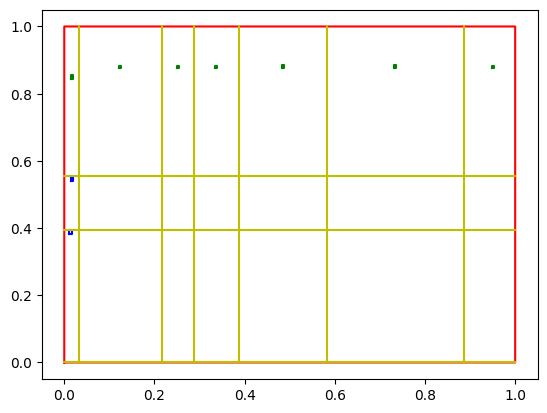

In [8]:
# PLOT

# plot the rectangle of the sheet

# Plot the four corner points of the page object to create a rectangle

# Save the page object
page_object = response['Blocks'][0]  # Assuming the page object is the first block

page_polygon = page_object['Geometry']['Polygon']
page_x = [point['X'] for point in page_polygon]
page_y = [point['Y'] for point in page_polygon]
page_x.append(page_x[0])
page_y.append(page_y[0])
plt.plot(page_x, page_y, 'r-')  # Connect the corner points in red

# for line in vertical_lines:
#     # Create and plot lines that extend indefinitely in both directions
#     plt.plot([line, line], [0, 1], 'b-')

for number in numbers:
    # Extract the bounding box coordinates from the line object
    bbox = number['Geometry']['BoundingBox']
    left = bbox['Left']
    top = bbox['Top']
    width = bbox['Width']
    height = bbox['Height']

    # Calculate the coordinates of the bounding box
    x1 = left
    x2 = left + width
    y1 = 1 - top
    y2 = 1 - top + height

    # Plot the bounding box
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'g-')

for entry_numbers in line_groups[0]:
    # Extract the bounding box coordinates from the line object
    bbox = entry_numbers['Geometry']['BoundingBox']
    left = bbox['Left']
    top = bbox['Top']
    width = bbox['Width']
    height = bbox['Height']

    # Calculate the coordinates of the bounding box
    x1 = left
    x2 = left + width
    y1 = 1 - top
    y2 = 1 - top + height

    # Plot the bounding box
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')

for divider in x_dividers:
    plt.plot([divider, divider], [0, 1], 'y-')

for divider in y_dividers:
    plt.plot([0, 1], [1-divider, 1-divider], 'y-')

plt.show()

In [9]:
# print text of all blocks in response object if they are LINE objects
for block in response['Blocks']:
    if block['BlockType'] == 'LINE':
        print(block['Text'])

Blatt
Amtsgericht SAARLOUIS
Tausender
Hunderter
Zehner
Dieses Blatt ist gelöscht4352
Tausender
Hunderter
Zehner
13579
Jetzt Amtsgenian
24680
Nr.
Grund-
Vorstand
a) Firma
HR B 4359
Persönlich haftende
der
oder
b) Sitz
Gesellschafter
Prokura
Ein-
Stammkapital
a) Tag der Eintragung
c) Gegenstand des Unternehmens
Geschäftsführer
Rechtsverhältnisse
und Unterschrift
tragung
DM
Abwickler
b) Bemerkungen
2
3
4
5
6
7
1
a) Aktiengesellschaft für
3.500.000,
Hans Strauß,
Aktiengesellschaft
a) 16.Sept. 1983
chemische Industrie
Deutsche
Kaufmann in
Die Satzung ist am 25. Januar 1872 festgestellt
Mark
Saarlouis
und später mehrfach, zuletzt am 24. Juni 1983
b) Saarlouis
in § 1 (Sitz der Gesellschaft) und § 15
Justizangestellter
c) Gegenstand des Unternehmens
(Ort der Hauptversammlung) geändert worden.
Der Vorstand besteht aus einer Person.
b) bisher Amtsge-
ist der Erwerb und die Ver-
richt Gelsen-
waltung von Beteiligungen
kirchen
an Industrie- Handels- und
HRB 187
Dienstleistungsunternehmen
Ersteintr